# CS 4782 Final Project: Feature Pyramid Networks for Object Detection:
Originally authored by Tsung-Yi Lin, Piotr Dollar, Ross Girshick, Kaiming He, Bharath Hariharan, and Serge Belongie

**Reimplemented by Jack Jansons (jcj59), Rob Mosher (ram487), Raphael Thesmar (rft38)**

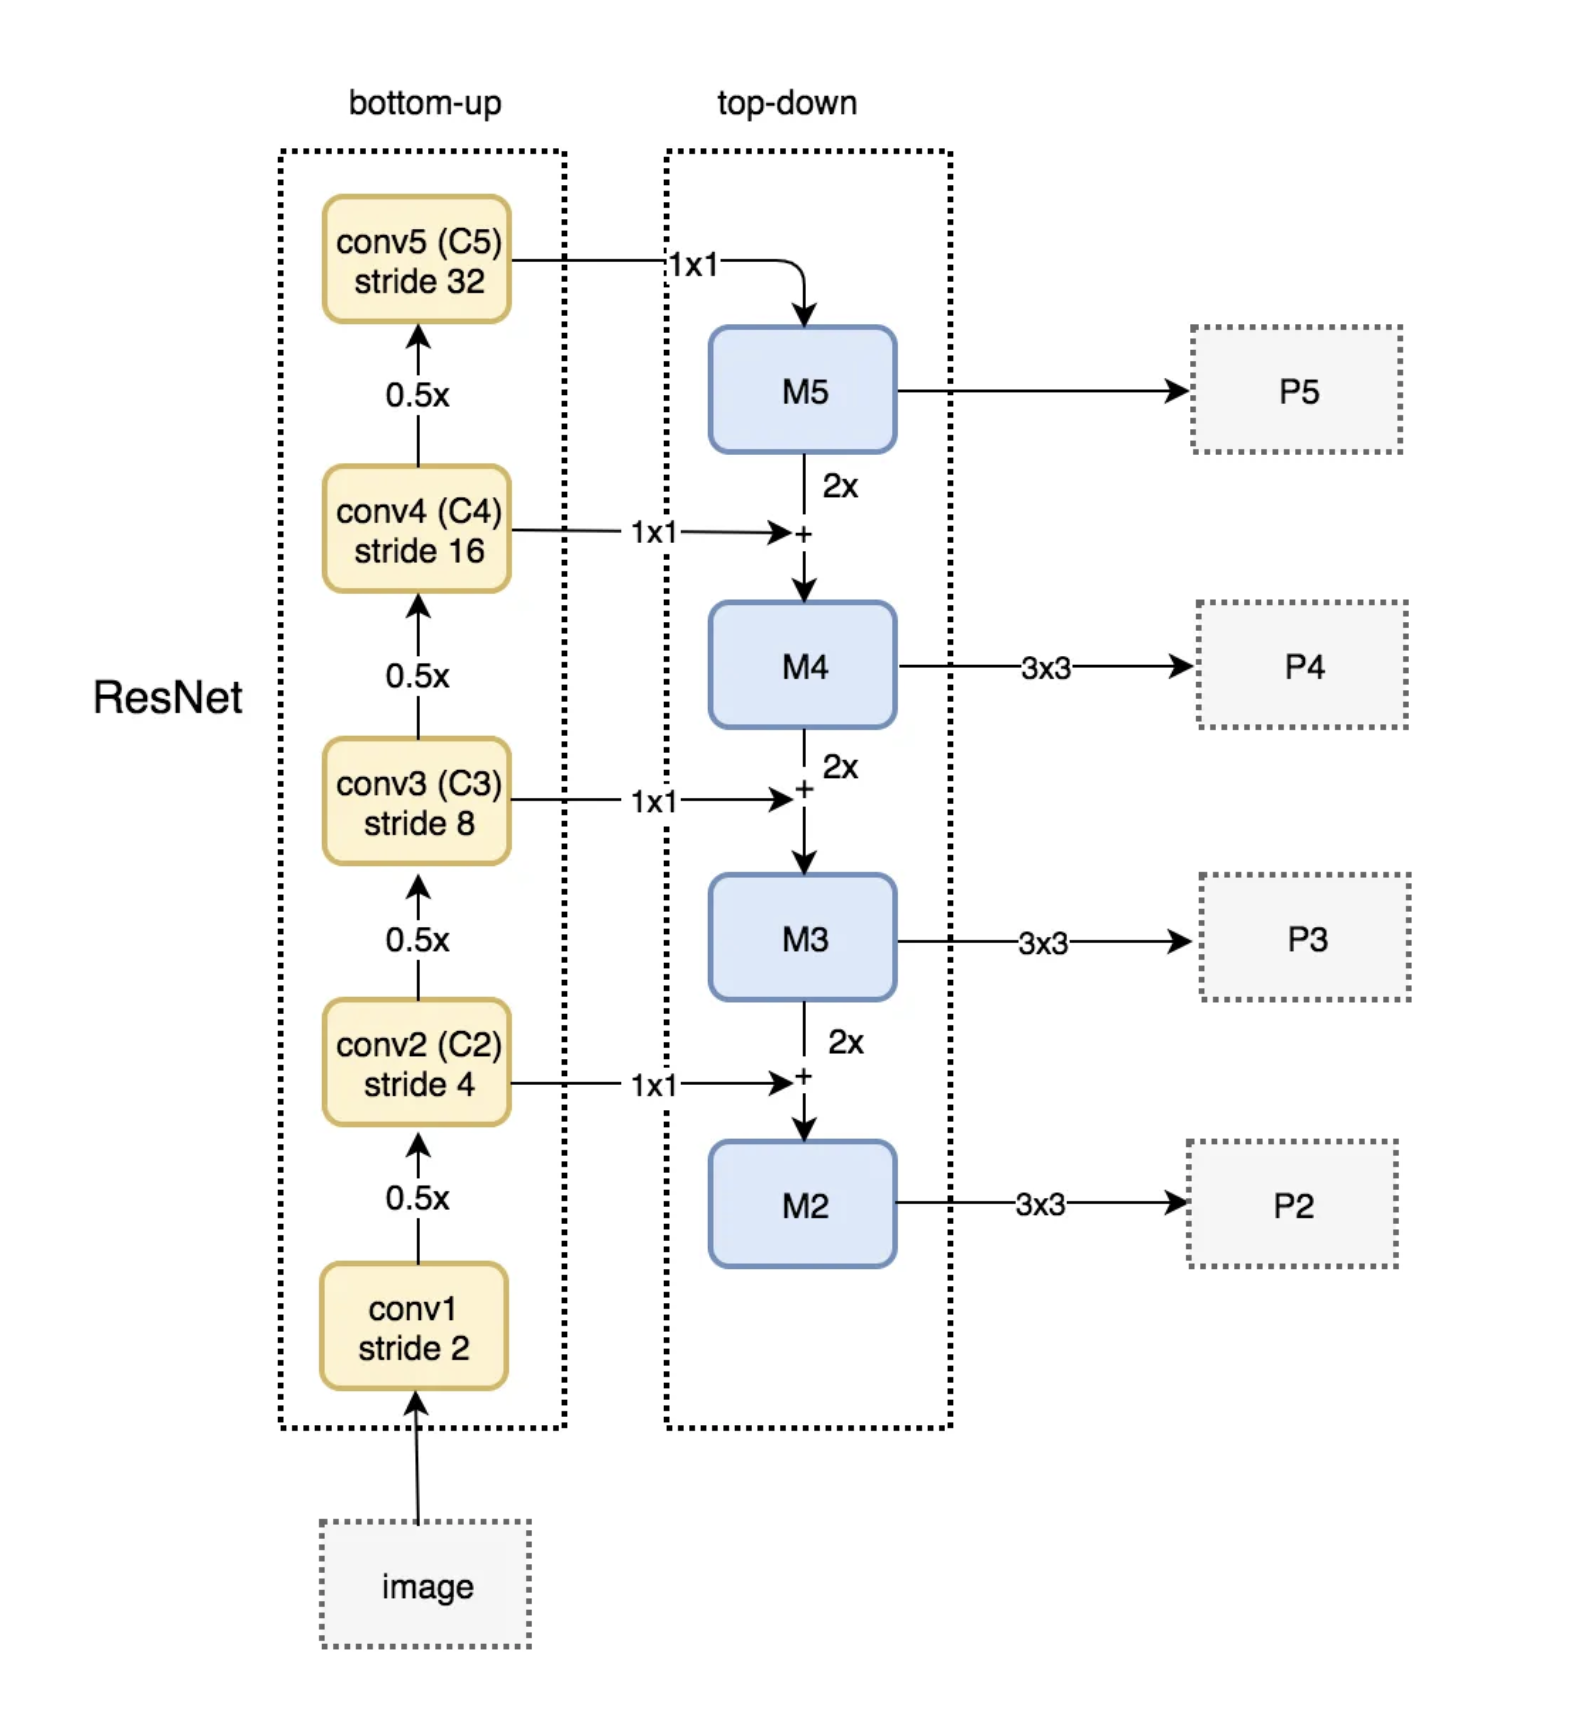



## Import Packages

In [ ]:
!pip install torch torchvision pycocotools einops datasets fiftyone

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [ ]:
from detectron2.config import get_cfg
from detectron2.modeling import build_model, BACKBONE_REGISTRY, Backbone, ShapeSpec
from detectron2.engine import DefaultTrainer, DefaultPredictor, SimpleTrainer, hooks, HookBase
from detectron2.data.datasets import register_coco_instances
from detectron2.data import build_detection_train_loader, build_detection_test_loader, DatasetCatalog, MetadataCatalog, DatasetMapper
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.checkpoint import PeriodicCheckpointer, DetectionCheckpointer
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.utils.events import EventStorage
from detectron2 import model_zoo


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet34
from torchvision.models.resnet import resnet50
import torchvision.models as models
from torchvision.models.resnet import ResNet34_Weights


import cv2
import random
from google.colab.patches import cv2_imshow
import json
import shutil
import time
import logging

## Download and Preprocess Data
Download COCO dataset

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
#!wget http://images.cocodataset.org/zips/test2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# Unzip the files
!unzip train2017.zip
!unzip val2017.zip
#!unzip test2017.zip
!unzip annotations_trainval2017.zip

In [ ]:
# Remove dataset in case you need to change something
DatasetCatalog.remove("coco_ds_train")
DatasetCatalog.remove("coco_ds_val")

In [ ]:
# Register images with Detectron2
train_annotations_path = "/content/annotations/instances_train2017.json"
train_images_path = "/content/train2017"
val_annotations_path = "/content/annotations/instances_val2017.json"
val_images_path = "/content/val2017"

register_coco_instances("coco_ds_train", {}, train_annotations_path, train_images_path)
register_coco_instances("coco_ds_val", {}, val_annotations_path, val_images_path)
#register_coco_instances("coco_dataset_test", {}, test_annotations_path, test_images_path)

For overfitting our model we create a smaller dataset of just the first 8 images in the COCO dataset.

In [ ]:
# Load the original annotations
with open("/content/annotations/instances_train2017.json", 'r') as f:
    data = json.load(f)

# Select the first 8 images
first_8_images = data['images'][:8]
image_ids = {img['id'] for img in first_8_images}

# Filter annotations to include only those that correspond to the first 8 images
filtered_annotations = [anno for anno in data['annotations'] if anno['image_id'] in image_ids]

# Create a new dictionary for the smaller dataset
small_dataset = {
    "info": data['info'],
    "licenses": data['licenses'],
    "images": first_8_images,
    "annotations": filtered_annotations,
    "categories": data['categories']
}

# Save the new annotations file
with open("/content/annotations/small_instances_train2017.json", 'w') as f:
    json.dump(small_dataset, f)

# Create a directory for the smaller train dataset
os.makedirs('/content/small_train2017', exist_ok=True)

# Copy the first 8 images
for image_info in first_8_images:
    filename = image_info['file_name']
    src_path = os.path.join('/content/train2017', filename)
    dst_path = os.path.join('/content/small_train2017', filename)
    shutil.copy(src_path, dst_path)

# Register the new smaller dataset
register_coco_instances("coco_ds_small_train", {}, "/content/annotations/small_instances_train2017.json", "/content/small_train2017")

## Implement Architecture


- The bottom-up pathway is the feedforward computation of the backbone ConvNet, which computes a feature hierarchy consisting of feature maps at several scales with a scaling step of 2.
- There are often many layers producing output maps of the same size and we say these layers are in the same network stage. For our feature pyramid, we define one pyramid level for each stage.
- We choose the output of the last layer of each stage as our reference set of feature maps, which we will enrich to create our pyramid.
- In this paper, we present results **using ResNets.**

### Top-Down Architecture

- The top-down pathway hallucinates higher resolution features by upsampling spatially coarser, but semantically stronger, feature maps from higher pyramid levels.
- These features are then enhanced with features from the bottom-up pathway via lateral connections.
- Each lateral connection merges feature maps of the same spatial size from the bottom-up pathway and the top-down pathway
The bottom-up feature map is of lower-level semantics, but its activations are more accurately localized as it was subsampled fewer times.
- With a coarser-resolution feature map, we upsample the spatial resolution by a factor of 2, using nearest neighbor upsampling for simplicity. The upsampled map is then merged with the corresponding bottom-up map (which undergoes a 1×1 convolutional layer to reduce channel dimensions) by element-wise addition
- This process is iterated until the finest resolution map is generated
To start the iteration, we simply attach a 1×1 convolutional layer on C5 to produce the coarsest resolution map.
- Finally, we append a 3×3 convolution on each merged map to generate the final feature map, which is to reduce the aliasing effect of upsampling.
This final set of feature maps is called {P2, P3, P4, P5}, corresponding to {C2, C3, C4, C5} that are respectively of the same spatial sizes.




### Custom Residual Block Implementation

In [ ]:
# Custom residual block implementation.
class BottomUpBlock(nn.Module):
  def __init__(self, in_channels=3, interm_channels=3, out_channels=3, stride=1):
      """
      Initialize a ResBlock.

      Inputs:
      in_channel = number of channels in the input to the first convolutional layer
      interm_channel = number of channels in the output of the first convolutional layer
                      = number of channels in the input to the second convolutional layer
      out_channel = number of channels in the output
      stride = stride for convolution, defaults to 1
      """
      super().__init__()

      self.conv1 = nn.Conv2d(in_channels, interm_channels, kernel_size=3, stride=stride, padding=1)
      self.bn1 = nn.BatchNorm2d(interm_channels)
      self.conv2 = nn.Conv2d(interm_channels, out_channels, kernel_size=3, stride=1, padding=1)
      self.bn2 = nn.BatchNorm2d(out_channels)

      self.shortcut = nn.Sequential()
      if stride != 1 or in_channels != out_channels:
          self.shortcut = nn.Sequential(
              nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
              nn.BatchNorm2d(out_channels)
          )

  def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = self.bn2(self.conv2(out))
      out += self.shortcut(x)
      out = F.relu(out)
      return out

In [ ]:
class FPN_CustomResBlock(nn.Module):
    def __init__(self):
      """
      Define FPN architecture with custom residual blocks.
      """
      super(FPN_CustomResBlock, self).__init__()

      # Upscale function for use in top-down section
      self.upscale = nn.Upsample(scale_factor=2, mode='nearest')

      # Bottom-Up Layers- Currently a Residual Block Abstraction. Downscale by 2x inbetween layers via increased stride.
      self.bu1 = BottomUpBlock(stride=2)
      self.bu2 = BottomUpBlock(stride=2)
      self.bu3 = BottomUpBlock(stride=2)
      self.bu4 = BottomUpBlock(stride=2)
      self.bu5 = BottomUpBlock(stride=2)
      self.bu6 = BottomUpBlock(stride=2)

      #1x1 convs for lateral connections: bump to 256 dimensions
      self.oneXone2 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=1, padding=0)
      self.oneXone3 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=1, padding=0)
      self.oneXone4 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=1, padding=0)
      self.oneXone5 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=1, padding=0)
      self.oneXone6 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=1, padding=0)

      # 3x3 conv layers to reduce aliasing after upsampling. Retain level footprint and d=256
      self.m_conv2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
      self.m_conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
      self.m_conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
      self.m_conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

    def forward(self, x):
      # c1 is not included in the output due to memory constraints
      c1 = self.bu1(x)
      c2 = self.bu2(c1)
      c3 = self.bu3(c2)
      c4 = self.bu4(c3)
      c5 = self.bu5(c4)
      c6 = self.bu6(c5)

      # Apply 1x1 convolutions
      conv_int6 = self.oneXone6(c6)
      conv_int5 = self.oneXone5(c5)
      conv_int4 = self.oneXone4(c4)
      conv_int3 = self.oneXone3(c3)
      conv_int2 = self.oneXone2(c2)

      # Apply 3x3 convolutions only to upsampled parts (NOT m5!)
      m6 = conv_int6
      p6 = m6

      m5 = conv_int5 + self.crop(conv_int5, self.upscale(m6))
      p5 = self.m_conv5(m5)

      m4 = conv_int4 + self.crop(conv_int4, self.upscale(m5))
      p4 = self.m_conv4(m4)

      m3 = conv_int3 + self.crop(conv_int3, self.upscale(m4))
      p3 = self.m_conv3(m3)

      m2 = conv_int2 + self.crop(conv_int2, self.upscale(m3))
      p2 = self.m_conv2(m2)

      # Output feature maps p2..p6
      return (p2, p3, p4, p5, p6)

    def crop(self, target, source):
      h = target.shape[2]
      w = target.shape[3]
      return source[:, :, :h, :w]


### ResNet34 Implementation

In [ ]:
class FPN_ResNet34(nn.Module):
    def __init__(self):
      """
      Define the entire FPN architecture.
      """
      super(FPN_ResNet34, self).__init__()

      resnet_bottom_up = resnet34(weights=ResNet34_Weights.DEFAULT)
      bottom_up_layers = list(resnet_bottom_up.children())[:-2]

      # Upscale function for use in top-down section
      self.upscale = nn.Upsample(scale_factor=2, mode='nearest')

      # Bottom-Up Layers. Downscale by 2x inbetween layers via increased stride.
      self.res2 = nn.Sequential(*bottom_up_layers[:5])
      self.res3 = bottom_up_layers[5]
      self.res4 = bottom_up_layers[6]
      self.res5 = bottom_up_layers[7]

      # Lateral Connections. Convert to 256 dimensions.
      self.fpn_lateral2 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=1, padding=0)
      self.fpn_lateral3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, padding=0)
      self.fpn_lateral4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, padding=0)
      self.fpn_lateral5 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, padding=0)


      # Output Networks. Retain 256 dimension.
      self.fpn_output2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
      self.fpn_output3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
      self.fpn_output4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
      self.fpn_output5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

      # Last-Level Pooling Layer
      self.top_block = nn.MaxPool2d(kernel_size=1, stride=2, padding=0)


    def forward(self, x):
      # c1 is not included in the output due to memory constraints
      # Normalize data
      x = x.float() / 255.0

      # Perform bottom up sequence
      c2 = self.res2(x)
      c3 = self.res3(c2)
      c4 = self.res4(c3)
      c5 = self.res5(c4)

      # Apply lateral connections
      lateral5 = self.fpn_lateral5(c5)
      lateral4 = self.fpn_lateral4(c4)
      lateral3 = self.fpn_lateral3(c3)
      lateral2 = self.fpn_lateral2(c2)

      # Apply 3x3 convolutions to generate outputs
      m5 = lateral5
      p5 = self.fpn_output5(m5)

      m4 = lateral4 + self.crop(lateral4, self.upscale(m5))
      p4 = self.fpn_output4(m4)

      m3 = lateral3 + self.crop(lateral3, self.upscale(m4))
      p3 = self.fpn_output3(m3)

      m2 = lateral2 + self.crop(lateral2, self.upscale(m3))
      p2 = self.fpn_output2(m2)

      p6 = self.top_block(p5)

      # Output feature maps p2..p6
      return (p2, p3, p4, p5, p6)

    def crop(self, target, source):
      """
      Crop source to match shape of target.
      """
      h = target.shape[2]
      w = target.shape[3]
      return source[:, :, :h, :w]

In [ ]:
# Test architecture works
batch_size = 1
num_channels = 3
height = 800
width = 800

# Create a random dummy input tensor
dummy_input = torch.randn(batch_size, num_channels, height, width)
resnet_bottom_up = resnet34(pretrained=True)
bottom_up_layers = list(resnet_bottom_up.children())[:-2]

test_model = FPN_ResNet34()
test_model.forward(dummy_input)

## Training
- Our paper uses object/nonobject criterion and bounding box regression targets defined with respect to a set of reference boxes called anchors. The anchors are of multiple pre-defined scales and aspect ratios in order to cover objects of different shapes.


### Register FPN Backbones with Detectron2


In [ ]:
# Custom Residual Block Backbone
@BACKBONE_REGISTRY.register()
class FPN_CustomResBlock_Backbone(Backbone):
    def __init__(self, cfg, input_shape: ShapeSpec):
        super().__init__()
        self.fpn = FPN_CustomResBlock()
        self._out_features = ['p2', 'p3', 'p4', 'p5', 'p6']

    def forward(self, tensor):
        outputs = self.fpn(tensor)
        return {f'p{i+2}': out for i, out in enumerate(outputs)}

    def output_shape(self):
        return {name: ShapeSpec(channels=256, stride=2 ** (i + 1)) for i, name in enumerate(self._out_features)}

In [ ]:
# ResNet34 Backbone
@BACKBONE_REGISTRY.register()
class FPN_ResNet34_BackBone(Backbone):
    def __init__(self, cfg, input_shape: ShapeSpec):
        super().__init__()
        self.fpn = FPN_ResNet34()
        self._out_features = ['p2', 'p3', 'p4', 'p5', 'p6']

    def forward(self, tensor):
        outputs = self.fpn(tensor)
        return {f'p{i+2}': out for i, out in enumerate(outputs)}

    def output_shape(self):
        return {name: ShapeSpec(channels=256, stride=2 ** (i + 1)) for i, name in enumerate(self._out_features)}

### Initialize Model and Training Parameters

In [ ]:
# Set up Detectron2 configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") # Load pretrained weights for RPN and Fast R-CNN Head

# Update the config for custom backbone
cfg.MODEL.BACKBONE.NAME = "FPN_ResNet34_BackBone" # Load custom FPN backbone
#cfg.MODEL.ROI_HEADS.NUM_CLASSES = 80
cfg.DATASETS.TRAIN = ("coco_ds_train",) # Load datasets
cfg.DATASETS.VALIDATION = ("coco_ds_val",)
cfg.OUTPUT_DIR = "/content/outputs"

# Set pretrained model weights
cfg.MODEL.WEIGHTS = "/content/outputs/model_0019999.pth"

# Update training parameters
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = .02
cfg.SOLVER.STEPS = (28000, 35000)
cfg.SOLVER.MAX_ITER = 40000

#cfg.INPUT.MIN_SIZE_TRAIN = (640, 672, 704, 736, 768, 800)

model = build_model(cfg)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the custom backbone parameters
# You need to ensure the custom backbone is registered and named properly as 'FPN_ResNet34_BackBone'
# Adjust 'FPN_ResNet34_BackBone' to the exact name used in registration if different
for name, parameter in model.named_parameters():
    if 'backbone' in name:  # Adjust the string to match the naming of your custom backbone in its definition
        parameter.requires_grad = True

# Optionally, check which parameters are trainable
for name, param in model.named_parameters():
    print(f"{name} is {'trainable' if param.requires_grad else 'frozen'}")

### Train Model

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

## Testing and Visualization


### Custom Model Visualization

In [ ]:
# Set up Detectron2 configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") # Load pretrained weights for RPN and Fast R-CNN Head

# Update the config for custom backbone
cfg.MODEL.BACKBONE.NAME = "FPN_ResNet34_BackBone" # Load custom FPN backbone
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 80
cfg.DATASETS.TRAIN = ("coco_ds_train",) # Load datasets
cfg.DATASETS.VALIDATION = ("coco_ds_train",)
cfg.OUTPUT_DIR = "/content/outputs"

# Set pretrained model weights
cfg.MODEL.WEIGHTS = "/content/outputs/model_0029999.pth"

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2

model = build_model(cfg)
predictor = DefaultPredictor(cfg)

[05/14 23:40:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/outputs/model_0029999.pth ...


In [ ]:
output_dir = "/content/images"
os.makedirs(output_dir, exist_ok=True)

# Choose images
images = os.listdir("/content/small_train2017")
#images = random.sample(os.listdir("/content/train2017/"), 8)

# Load images
image_paths = []
for image in images:
  image_paths.append("/content/train2017/"+image)

ims = []
for image_path in image_paths:
  ims.append(cv2.imread(image_path))

i = 0
# Run model and visualize
for im in ims:
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

  image_name = image_paths[i].split('/')[-1]
  output_path = f'/content/images/visualized_{image_name}'
  cv2.imwrite(output_path, out.get_image()[:, :, ::-1])
  i += 1

### Pretrained Model Visualization

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
model = build_model(cfg)

In [ ]:
# Choose images
images = os.listdir("/content/small_train2017")
#images = random.sample(os.listdir("/content/train2017/"), 8)

# Load images
image_paths = []
for image in images:
  image_paths.append("/content/train2017/"+image)

ims = []
for image_path in image_paths:
  ims.append(cv2.imread(image_path))

# Run model and visualize
i = 0
for im in ims:
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

  image_name = image_paths[i].split('/')[-1]
  output_path = f'/content/images/visualized_{image_name}'
  cv2.imwrite(output_path, out.get_image()[:, :, ::-1])
  i += 1

## Result Replication Testing

In [ ]:
evaluator = COCOEvaluator("coco_ds_small_train", output_dir="/output/")
val_loader = build_detection_test_loader(cfg, "coco_ds_small_train")
results = inference_on_dataset(predictor.model, val_loader, evaluator)
file_path = 'small_resnet_improved.json'
with open(file_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, sort_keys=True, ensure_ascii=False)

In [ ]:
evaluator = COCOEvaluator("coco_ds_val", output_dir="/output/")
val_loader = build_detection_test_loader(cfg, "coco_ds_val")
results = inference_on_dataset(predictor.model, val_loader, evaluator)
file_path = 'pretrained_resnet_full.json'
with open(file_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, sort_keys=True, ensure_ascii=False)